<a href="https://colab.research.google.com/github/DavinciB/child_grooming_detector/blob/main/Grooming%20Attempt%20Identifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import xml.etree.ElementTree as ET
import csv


def get_labels_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict

def get_features_labels(root, labels_dict):
    corpus = []
    labels = []
    for conversation in root:
        string = " "
        for message in conversation:
            text = message.find('text').text
            if text is not None:
                string = string + "\r\n" + text
        corpus.append(string)
        labels.append(int(labels_dict[conversation.get('id')]))
    return corpus, labels

In [4]:
train_data_path = '/content/drive/MyDrive/online-grooming-detector-master/data/svm_training_data/'
training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()
test_data_path = '/content/drive/MyDrive/online-grooming-detector-master/data/svm_test_data/'
test_data_src = '/content/drive/MyDrive/online-grooming-detector-master/data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_src + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()
train_corpus, train_labels = get_features_labels(train_root, get_labels_dict(train_data_path))
test_corpus, test_labels = get_features_labels(test_root, get_labels_dict(test_data_path))

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy
import numpy as np

vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_corpus)
X_test = vectorizer.transform(test_corpus)
X_train = scipy.sparse.csr_matrix(X_train)
y_train = np.array(train_labels)
X_test = scipy.sparse.csr_matrix(X_test)
y_test = np.array(test_labels)

c=0.1, Accuracy: 0.9917218543046358
c=0.2, Accuracy: 0.9937086092715232
c=0.30000000000000004, Accuracy: 0.9943708609271523
c=0.4, Accuracy: 0.994701986754967
c=0.5, Accuracy: 0.9950331125827814
c=0.6, Accuracy: 0.995364238410596
c=0.7000000000000001, Accuracy: 0.995364238410596
c=0.8, Accuracy: 0.9953642384105962
c=0.9, Accuracy: 0.9954304635761589
c=1.0, Accuracy: 0.995364238410596
c=1.1, Accuracy: 0.995364238410596
c=1.2000000000000002, Accuracy: 0.9952980132450332
c=1.3000000000000003, Accuracy: 0.9952980132450332
c=1.4000000000000001, Accuracy: 0.9954304635761589
c=1.5000000000000002, Accuracy: 0.9954966887417218
c=1.6, Accuracy: 0.9955629139072848
c=1.7000000000000002, Accuracy: 0.9955629139072848
c=1.8000000000000003, Accuracy: 0.9955629139072848
c=1.9000000000000001, Accuracy: 0.9955629139072848
c=2.0, Accuracy: 0.9955629139072848
c=2.1, Accuracy: 0.9955629139072848
c=2.2, Accuracy: 0.9954966887417218
c=2.3000000000000003, Accuracy: 0.9955629139072848
c=2.4000000000000004, Accu

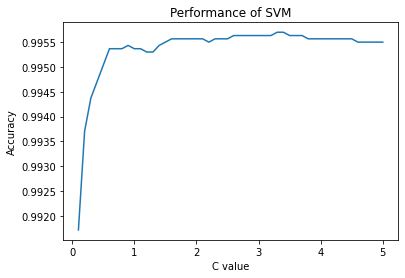

Best performing linear kernel SVM: C=3.3000000000000003, Acc=0.9956953642384105


In [6]:
from sklearn import svm
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import metrics
import heapq
import operator
import numpy as np
from sklearn.svm import LinearSVC

num_fold = 10
k_fold = KFold(num_fold, True, 1)
acc = []

for coef_c in np.arange(0.1, 5.1, 0.1):
    acc_arr = np.zeros(num_fold)
    ind = 0
    for train_rows, val_rows in k_fold.split(X_train):
        model = LinearSVC(random_state=0, C=coef_c, loss='squared_hinge', dual=True)
        model.fit(X_train[train_rows], y_train[train_rows])
        pred_y = model.predict(X_train[val_rows])
        acc_arr[ind] = metrics.accuracy_score(y_train[val_rows], pred_y)
        ind += 1
    acc.append([coef_c, np.mean(acc_arr)])
    print("c={}, Accuracy: {}".format(coef_c, acc[len(acc)-1][1]))
plt.plot([i[0] for i in acc], [i[1] for i in acc])
plt.title("Performance of SVM")
plt.xlabel("C value")
plt.ylabel("Accuracy")
plt.show()
best = heapq.nlargest(1, acc, key=operator.itemgetter(1))[0]
print("Best performing linear kernel SVM: C={}, Acc={}".format(best[0], best[1]))

In [7]:
model = LinearSVC(random_state=0, C=best[0], loss='squared_hinge', dual=True)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)
print(metrics.accuracy_score(y_test, pred_y))

0.9851026249290908


In [8]:
import pickle
import datetime
filename = '/content/drive/MyDrive/online-grooming-detector-master/models/GAI_SVM.sav'
pickle.dump(model, open(filename, 'wb'))